In [1]:
import numpy as np
import h5py
import pandas as pd
import re


from itertools import islice
from collections import Counter

from io import BytesIO

In [2]:
df = pd.read_csv('table.csv')

/var/folders/xm/lz8thrrs1l5cks282q243ty40000gn/T/ipykernel_1310/1710511514.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('table.csv')


In [74]:
macrophage= df[df['source_name_ch1'].str.contains('[mM]acrophage|[mM]acrophages', case=False, na=False)]

In [75]:
macrophages=macrophage[~macrophage['source_name_ch1'].str.contains('[bB]one [mM]arrow', case=False, na=False)]

In [78]:
platform_count=macrophages.groupby('platform_id')['source_name_ch1'].value_counts() 

In [80]:
res=df[df.geo_accession.isin(macrophages.geo_accession)].reset_index(drop=False)
indices=res['index']
indices2=[]
for i in indices:
    f=i
    indices2.append(f)

In [86]:
with h5py.File('mouse_matrix_v11.h5', 'r') as f:
    data_set = f['data']['expression']
    data=data_set[::,indices2]
    expression = pd.DataFrame(data, columns=indices)
    f.close()

In [87]:
expression.columns = df.loc[indices]['geo_accession']
print(expression.head())

geo_accession  GSM1533925  GSM1823626  GSM814845  GSM1533946  GSM1119599  \
0                     117         326        267         130         146   
1                      78         237         12          50         245   
2                       4          15         24           6          51   
3                     112         558         73         255         701   
4                     261         948        379         392          94   

geo_accession  GSM1131273  GSM1103016  GSM1406427  GSM1930804  GSM1026902  \
0                     498         284        1110         395         210   
1                     177          95         594         348         100   
2                      19          15          39          22          17   
3                     274         648         784         355         643   
4                     706         154        1268         425         257   

geo_accession  ...  GSM5508820  GSM5514049  GSM5514051  GSM5550906  \
0         

In [83]:
with h5py.File('mouse_matrix_v11.h5', 'r') as f:
    data_set = f['meta']['genes']['genes']
    data=data_set[::]
    names_lines = pd.DataFrame(data)
    ensembl_set=f['meta']['genes']['ensembl_gene_id']
    ensembl=ensembl_set[::]
    ensemble = pd.DataFrame(ensembl) 
    for col, dtype in names_lines.dtypes.items():
        if dtype == np.object_:  # Only process byte object columns.
            names_lines[col] = names_lines[col].apply(lambda x: x.decode("utf-8"))
    for col, dtype in ensemble.dtypes.items():
        if dtype == np.object_:  # Only process byte object columns.
            ensemble[col] = ensemble[col].apply(lambda x: x.decode("utf-8"))
    f.close()
print(names_lines.head())
print(ensemble.head())
print(len(ensemble))
print(len(names_lines))

               0
0  0610007P14Rik
1  0610009B22Rik
2  0610009L18Rik
3  0610009O20Rik
4  0610010F05Rik
                    0
0             missing
1  ENSMUSG00000007777
2  ENSMUSG00000043644
3             missing
4  ENSMUSG00000042208
32544
32544


In [109]:
expression2 = pd.concat([ensemble, expression], axis=1)

In [115]:
expression2.rename(columns={0: "ensemble"}, inplace=True)

In [119]:
dee = pd.read_csv('dee.csv') #маленькая таблица
dee.pop('Unnamed: 0')
exp=expression2.sort_values(by=['ensemble'])
dee=dee.sort_values(by=['ensemble'])


32544
52636


In [121]:
dee_cross=dee[dee['ensemble'].isin(exp['ensemble'])]
print(dee_cross.head())
print(dee_cross.shape[0])

                 ensemble symbol  GSM4042993  GSM4042994  GSM4042995  \
11893  ENSMUSG00000000001  Gnai3        3962        3807        2487   
8469   ENSMUSG00000000003   Pbsn           0           0           0   
46315  ENSMUSG00000000028  Cdc45        1254        1209        1144   
9726   ENSMUSG00000000037  Scml2           0           0           1   
39400  ENSMUSG00000000049   Apoh           0           0           3   

       GSM4042996  GSM4042997  GSM4042998  GSM4042999  GSM4043000  ...  \
11893        3122        3196        2420        5688        7300  ...   
8469            0           0           0           0           0  ...   
46315        1362        1310        1264        1109        1569  ...   
9726            1           0           0           2           0  ...   
39400           0           1           4           0           0  ...   

       GSM1234735  GSM1234736  GSM1234737  GSM1234738  GSM1234739  GSM1234740  \
11893        4077        4671        7293

In [122]:
exp_cross=exp[exp.ensemble.isin(dee_cross.ensemble)  ]
print(exp_cross.head())
print(exp_cross.shape[0])

                 ensemble  GSM1533925  GSM1823626  GSM814845  GSM1533946  \
16843  ENSMUSG00000000001        1079       14678       1043        3307   
23599  ENSMUSG00000000003           0           0          0           0   
3402   ENSMUSG00000000028          14         181        134          32   
26959  ENSMUSG00000000037           0           7         20          14   
1743   ENSMUSG00000000049           0           5          0           0   

       GSM1119599  GSM1131273  GSM1103016  GSM1406427  GSM1930804  ...  \
16843         678        6920        3542       10032        1792  ...   
23599           0           0           0           0           0  ...   
3402          856          25          42         653         113  ...   
26959           0           6           0          27           2  ...   
1743            1           0           0           1           0  ...   

       GSM5508820  GSM5514049  GSM5514051  GSM5550906  GSM5550908  GSM5550909  \
16843        3186

In [125]:
dee_cross.pop('symbol')

11893         Gnai3
8469           Pbsn
46315         Cdc45
9726          Scml2
39400          Apoh
            ...    
41415    AC154506.4
42275    AC238811.3
42281    AC238940.3
42273    AC238811.4
6028     AL844586.1
Name: symbol, Length: 30608, dtype: object

In [127]:
exp_cross = exp_cross[sorted(exp_cross.columns )]
dee_cross = dee_cross[sorted(dee_cross.columns )]
print(exp_cross.head())
print(dee_cross.head())

       GSM1026888  GSM1026889  GSM1026890  GSM1026891  GSM1026892  GSM1026893  \
16843        5567        5857        4467        5325        6059        5579   
23599           0           0           0           0           0           0   
3402           16          61          12          85         124         172   
26959           2           6           5           0           3          12   
1743            2           0           1           1           0           0   

       GSM1026894  GSM1026895  GSM1026896  GSM1026897  ...  GSM951560  \
16843        4753        5581        4557        3708  ...        730   
23599           0           0           0           0  ...          0   
3402          117         188           7          29  ...        147   
26959          10          16           1           3  ...          4   
1743            2           0           3           1  ...          0   

       GSM951561  GSM951562  GSM951563  GSM951564  GSM951565  GSM951566  \

In [128]:
col=dee_cross.columns
g=[]
for i in col:
    g.append(i)

In [129]:
exp_cross=exp_cross.loc[:, exp_cross.columns.intersection(g)]
col=exp_cross.columns
h=[]
for i in col:
    h.append(i)
dee_cross=dee_cross.loc[:, dee_cross.columns.intersection(h)]

In [130]:
exp_cross

,GSM1026888,GSM1026889,GSM1026890,GSM1026891,GSM1026892,GSM1026893,GSM1026894,GSM1026895,GSM1026896,GSM1026897,...,GSM951560,GSM951561,GSM951562,GSM951563,GSM951564,GSM951565,GSM951566,GSM951567,GSM951568,ensemble
16843,5567,5857,4467,5325,6059,5579,4753,5581,4557,3708,...,730,1378,1090,1446,2473,2214,2912,6433,3521,ENSMUSG00000000001
23599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ENSMUSG00000000003
3402,16,61,12,85,124,172,117,188,7,29,...,147,246,123,33,266,274,196,138,41,ENSMUSG00000000028
26959,2,6,5,0,3,12,10,16,1,3,...,4,12,4,4,14,17,13,11,5,ENSMUSG00000000037
1743,2,0,1,1,0,0,2,0,3,1,...,0,0,0,0,0,0,0,1,0,ENSMUSG00000000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,2,0,2,1,ENSMUSG00000114816
11777,29,10,24,49,61,50,31,69,47,13,...,12,0,0,0,0,14,0,11,17,ENSMUSG00000114871
11778,0,0,0,1,0,4,0,0,5,0,...,0,10,4,9,73,62,104,261,147,ENSMUSG00000114940
11518,0,0,0,1,0,4,0,0,5,0,...,0,10,4,9,73,62,104,261,147,ENSMUSG00000114951


In [131]:
dee_cross

,GSM1026888,GSM1026889,GSM1026890,GSM1026891,GSM1026892,GSM1026893,GSM1026894,GSM1026895,GSM1026896,GSM1026897,...,GSM951560,GSM951561,GSM951562,GSM951563,GSM951564,GSM951565,GSM951566,GSM951567,GSM951568,ensemble
11893,1857,1946,1460,1731,2064,1829,1524,1851,1452,1211,...,856,1528,1238,1618,2624,2351,3018,6720,3657,ENSMUSG00000000001
8469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ENSMUSG00000000003
46315,6,17,4,27,46,61,43,58,1,7,...,157,252,126,37,281,295,206,146,43,ENSMUSG00000000028
9726,0,1,1,0,1,4,3,3,1,0,...,4,11,5,3,12,15,9,10,3,ENSMUSG00000000037
39400,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,ENSMUSG00000000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ENSMUSG00000114816
42275,18,26,18,22,24,16,11,16,9,16,...,2,4,4,12,2,1,0,10,7,ENSMUSG00000114871
42281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ENSMUSG00000114940
42273,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,2,0,1,ENSMUSG00000114951


In [132]:
exp_cross.to_csv('exp_macrophages.csv')
dee_cross.to_csv('dee_macrophages.csv')

In [133]:
import matplotlib.pyplot as plt
import scipy
import qnorm 
import seaborn as sns
import sklearn
import bioinfokit
import qnorm 
import os
import pickle as pkl
import pydeseq2


from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from bioinfokit.visuz import cluster
from rnanorm.normalization import cpm
from rnanorm.normalization import tpm
from rnanorm.normalization import quantile
from pydeseq2.DeseqDataSet import DeseqDataSet
from pydeseq2.DeseqStats import DeseqStats
from pydeseq2.utils import load_example_data

In [134]:
dee = pd.read_csv('dee_macrophages.csv')
exp = pd.read_csv('exp_macrophages.csv')
exp=exp.drop(columns = ['Unnamed: 0'],axis = 1)
dee=dee.drop(columns = ['Unnamed: 0'],axis = 1)
exp = exp.set_index('ensemble')
dee = dee.set_index('ensemble')

In [135]:
exp_mean=exp.mean(axis=1)
exp.insert(0, 'mean', exp_mean)
exp_sorted=exp.sort_values('mean',axis=0, ascending=False)
exp_sorted=exp_sorted.head(12000)
exp_sorted=exp_sorted.drop(columns = ['mean'],axis = 1)
index_list = exp_sorted.index.values.tolist ()
dee_sorted=dee.loc[index_list]

In [136]:
exp_top=exp_sorted
dee_top=dee_sorted

In [137]:
exp_top.to_csv('exp_m_top.csv')
dee_top.to_csv('dee_m_top.csv')

In [139]:
macrophages.to_csv('macrophages.csv')

In [140]:
corr=exp_top.corrwith(dee_top, axis=0, drop=False, method='pearson')
check=corr.index [corr>=0.9 ]. tolist ()
dee=dee_top.drop(columns = check, axis = 1, inplace=False)
exp=exp_top.drop(columns = check, axis = 1, inplace=False)

In [141]:
def pca_tsne_class(raws, great_table):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    from bioinfokit.analys import get_data
    from bioinfokit.visuz import cluster
    from bioinfokit.analys import norm
    import numpy as np
    from rnanorm.normalization import cpm
    from rnanorm.normalization import tpm
    from rnanorm.normalization import quantile
    col=['red', 'blue','green', 'darkviolet', 'black', 'lime', 'gold']
    
    b = cpm(raws)
    c=quantile(b)
    samples=np.log(c+1)
    samples = samples - samples.mean()
    
    geo_from_great=great_table['geo_accession'].values.tolist() # из большой таблицы все gsm вынимаем
    samples_choised=samples.loc[:, samples.columns.intersection(geo_from_great)] # в наших данных оставляем только те же gsm
    gsm_list=samples_choised.columns.values.tolist() # и переносим их в список
    classes_list=great_table['source_name_ch1'].loc[great_table['geo_accession'].isin(gsm_list)]
    target = classes_list
    df=samples_choised.transpose()
  

    
    pca_out = PCA().fit(df)
    loadings = pca_out.components_
    pca_out.explained_variance_
    
    pca_scores = PCA().fit_transform(df)
    tsne_score=TSNE(learning_rate='auto').fit_transform(df)
    

    cluster.tsneplot(score=tsne_score, colorlist=target, show=True, dotsize=2, legendpos='best', colordot=col, legendanchor=[1,1])
    cluster.biplot(cscore=pca_scores, loadings=loadings,labels=df.columns.values.tolist(), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), colorlist=target, show=True, dotsize=2, legendpos='best', colordot=col)

In [189]:
macrophages.source_name_ch1.value_counts().head(30)

macrophage single cell                                                                               423
macrophage                                                                                           384
bone-marrow derived macrophages (BMDMs) from 6-10 week old C57BL/6J mice                             151
Alveolar macrophages                                                                                 136
Macrophages                                                                                          123
Macrophage                                                                                           117
peritoneal macrophages                                                                               114
Peritoneal macrophages                                                                                92
macrophages                                                                                           90
AV node macrophage                                     

In [192]:
macro_selected= macrophages[macrophages['source_name_ch1'].str.contains('^[pP]eritoneal macrophages$|AV node macrophage|^Alveolar macrophages$|[cC]olon macrophage[s\s]$|hepatic macrophage[s\s]', case=False, na=False)]

In [193]:
macro_selected.source_name_ch1.value_counts().head(30)

Alveolar macrophages          136
peritoneal macrophages        114
Peritoneal macrophages         92
AV node macrophage             76
Sorted hepatic macrophages     33
colon macrophages              32
alveolar macrophages           16
Peritoneal Macrophages          8
Name: source_name_ch1, dtype: int64

In [194]:
conditions = [
    (macro_selected['source_name_ch1'].str.contains('^[pP]eritoneal macrophages$',case=False, regex=True)),
    (macro_selected['source_name_ch1'].str.contains('AV node macrophage',case=False, regex=True)),
    (macro_selected['source_name_ch1'].str.contains('^Alveolar macrophages$',case=False, regex=True)),
    (macro_selected['source_name_ch1'].str.contains('colon macrophages',case=False, regex=True)),    
    (macro_selected['source_name_ch1'].str.contains('hepatic macrophages',case=False, regex=True)),
]
values = ['Peritoneal macrophages', 'AV node macrophages', 'Alveolar macrophages','Colon macrophages', 'Hepatic macrophages']
macro_selected.insert(3, "Classes", np.select(conditions, values))


In [239]:
macro_selected.Classes.value_counts().head(30)

Peritoneal macrophages    214
Alveolar macrophages      152
AV node macrophages        76
Hepatic macrophages        33
Colon macrophages          32
Name: Classes, dtype: int64

In [225]:
def pca_tsne(raws, great_table):
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler
    from bioinfokit.analys import get_data
    from bioinfokit.visuz import cluster
    from bioinfokit.analys import norm
    import numpy as np
    from rnanorm.normalization import cpm
    from rnanorm.normalization import tpm
    from rnanorm.normalization import quantile
    col=['red', 'blue','green', 'darkviolet', 'black', 'lime', 'gold']
    
    b = cpm(raws)
    c=quantile(b)
    samples=np.log(c+1)
    samples = samples - samples.mean()
    
    geo_from_great=great_table['geo_accession'].values.tolist() # из большой таблицы все gsm вынимаем
    samples_choised=samples.loc[:, samples.columns.intersection(geo_from_great)] # в наших данных оставляем только те же gsm
    gsm_list=samples_choised.columns.values.tolist() # и переносим их в список
    classes_list=great_table['Classes'].loc[great_table['geo_accession'].isin(gsm_list)]
    target = classes_list
    df=samples_choised.transpose()
  

    
    pca_out = PCA().fit(df)
    loadings = pca_out.components_
    pca_out.explained_variance_
    
    pca_scores = PCA().fit_transform(df)
    tsne_score=TSNE(learning_rate='auto').fit_transform(df)
    

    cluster.tsneplot(score=tsne_score, colorlist=target, show=True, dotsize=2, legendpos='best', colordot=col, legendanchor=[1,1])
    cluster.biplot(cscore=pca_scores, loadings=loadings,labels=df.columns.values.tolist(), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), colorlist=target, show=True, dotsize=2, legendpos='best', colordot=col)

/Users/pavellebedev/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


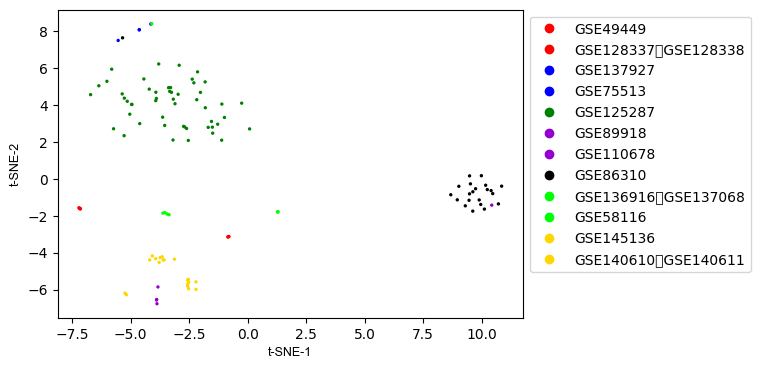

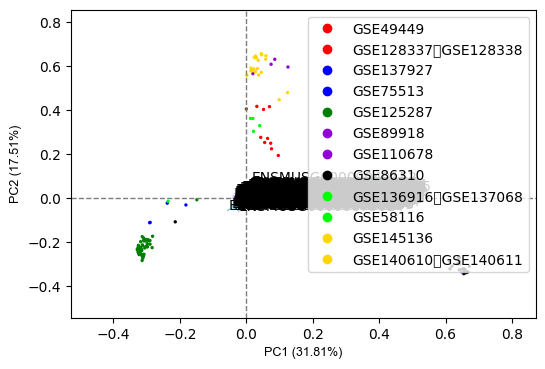

/Users/pavellebedev/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


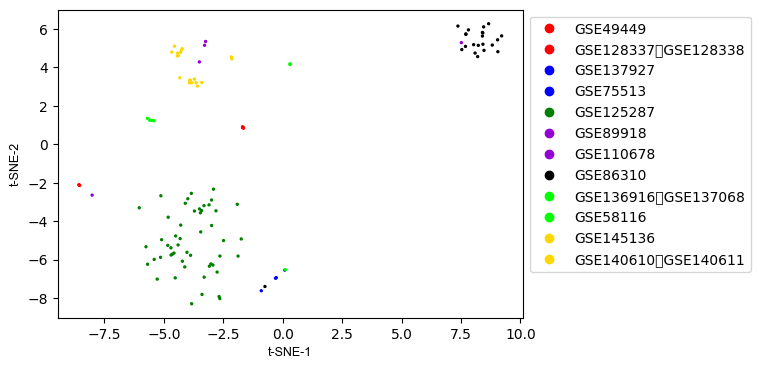

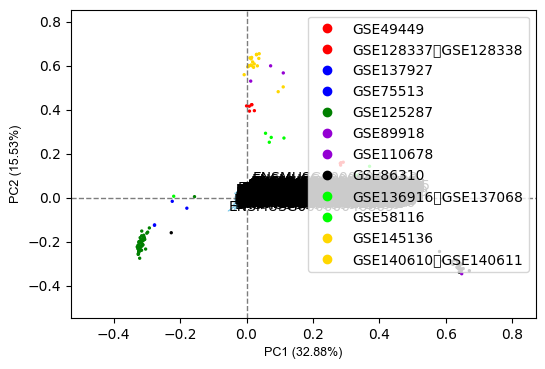

In [201]:
pca_tsne(exp, macro_selected)
pca_tsne(dee, macro_selected)

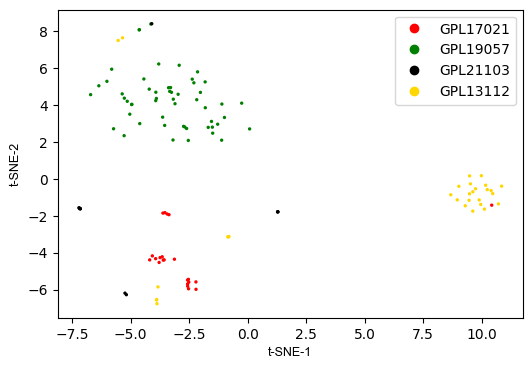

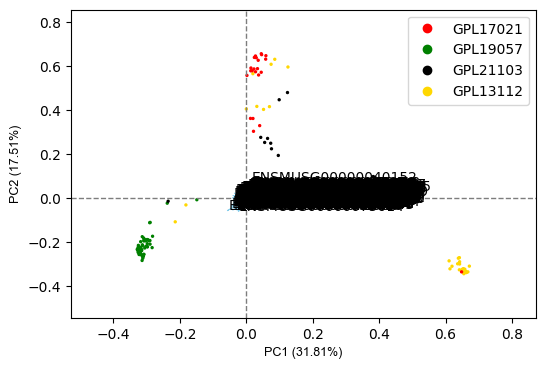

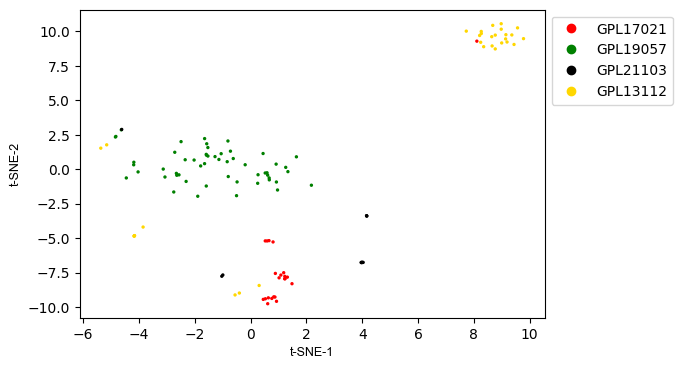

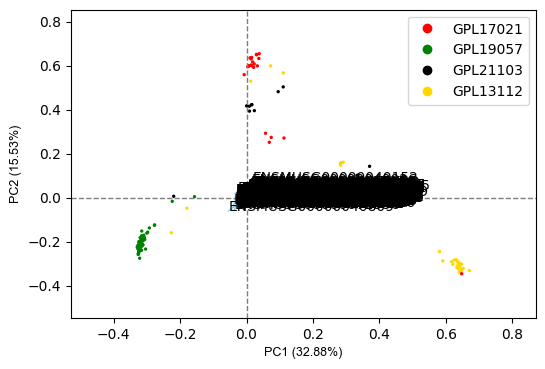

In [203]:
pca_tsne(exp, macro_selected)
pca_tsne(dee, macro_selected)

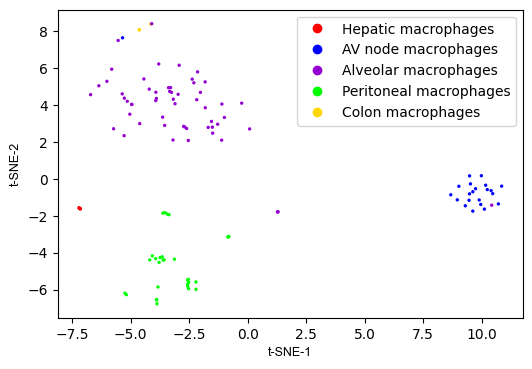

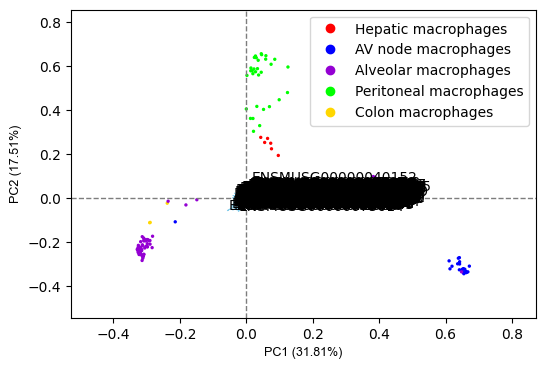

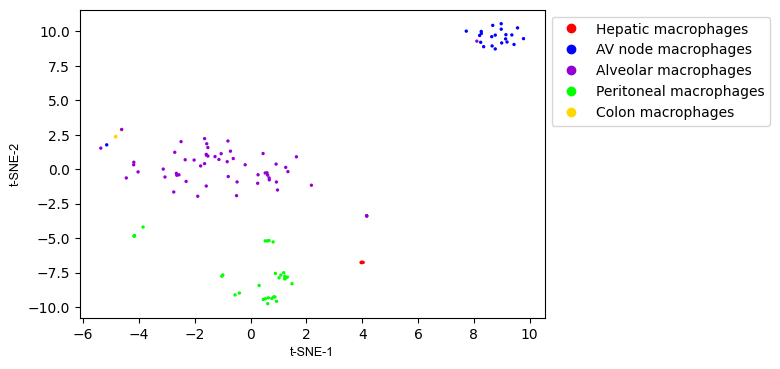

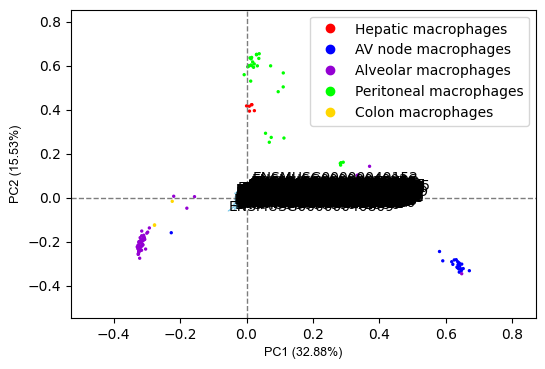

In [226]:
pca_tsne (exp, macro_selected)
pca_tsne (dee, macro_selected)

In [236]:
macro_selected

,Unnamed: 0,taxid_ch1,status,Classes,source_name_ch1,series_id,relation,readstotal,readsaligned,platform_id,...,library_strategy,library_selection,library_source,instrument_model,extract_protocol_ch1,characteristics_ch1,data_processing,geo_accession,type,title
5017,5017,10090,Public on May 12 2014,Peritoneal macrophages,Peritoneal macrophages,GSE49449,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,30382581,28709376,GPL13112,...,RNA-Seq,cDNA,transcriptomic,Illumina HiSeq 2000,TRIzol\tIllumina Standard protocol,strain: C57BL/6\ttissue: Thioglycolate-elicite...,rsem-calculate-expression --phred64-quals -see...,GSM1199323,SRA,pec_ptp1b_ko_untreated_rep2
8806,8806,10090,Public on May 12 2014,Peritoneal macrophages,Peritoneal macrophages,GSE49449,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,30468533,28783218,GPL13112,...,RNA-Seq,cDNA,transcriptomic,Illumina HiSeq 2000,TRIzol\tIllumina Standard protocol,strain: C57BL/6\ttissue: Thioglycolate-elicite...,rsem-calculate-expression --phred64-quals -see...,GSM1199327,SRA,pec_ptp1b_ko_+il10_rep2
11714,11714,10090,Public on May 12 2014,Peritoneal macrophages,Peritoneal macrophages,GSE49449,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,31152651,30016284,GPL13112,...,RNA-Seq,cDNA,transcriptomic,Illumina HiSeq 2000,TRIzol\tIllumina Standard protocol,strain: C57BL/6\ttissue: Thioglycolate-elicite...,rsem-calculate-expression --phred64-quals -see...,GSM1199326,SRA,pec_ptp1b_ko_+il10_rep1
12489,12489,10090,Public on May 12 2014,Peritoneal macrophages,Peritoneal macrophages,GSE49449,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,30358757,28761048,GPL13112,...,RNA-Seq,cDNA,transcriptomic,Illumina HiSeq 2000,TRIzol\tIllumina Standard protocol,strain: C57BL/6\ttissue: Thioglycolate-elicite...,rsem-calculate-expression --phred64-quals -see...,GSM1199325,SRA,pec_ptp1b_wt_untreated_rep2
14115,14115,10090,Public on May 12 2014,Peritoneal macrophages,Peritoneal macrophages,GSE49449,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,31568722,30024643,GPL13112,...,RNA-Seq,cDNA,transcriptomic,Illumina HiSeq 2000,TRIzol\tIllumina Standard protocol,strain: C57BL/6\ttissue: Thioglycolate-elicite...,rsem-calculate-expression --phred64-quals -see...,GSM1199328,SRA,pec_ptp1b_wt_+il10_rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476973,476973,10090,Public on May 19 2021,Peritoneal macrophages,Peritoneal Macrophages,GSE171413,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,45931488,44088056,GPL23479,...,RNA-Seq,cDNA,transcriptomic,BGISEQ-500,Total RNA was isolated from ox-LDL-treated per...,genotype: C57BL/6\tage: 8 weeks\ttreatment: un...,"Data quality was assessed with FastQC,\treads ...",GSM5225016,SRA,control 5
476974,476974,10090,Public on May 19 2021,Peritoneal macrophages,Peritoneal Macrophages,GSE171413,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,44550486,41810586,GPL23479,...,RNA-Seq,cDNA,transcriptomic,BGISEQ-500,Total RNA was isolated from ox-LDL-treated per...,genotype: C57BL/6\tage: 8 weeks\ttreatment: pr...,"Data quality was assessed with FastQC,\treads ...",GSM5225017,SRA,ox-LDL-1
476975,476975,10090,Public on May 19 2021,Peritoneal macrophages,Peritoneal Macrophages,GSE171413,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,44585836,41920949,GPL23479,...,RNA-Seq,cDNA,transcriptomic,BGISEQ-500,Total RNA was isolated from ox-LDL-treated per...,genotype: C57BL/6\tage: 8 weeks\ttreatment: pr...,"Data quality was assessed with FastQC,\treads ...",GSM5225019,SRA,ox-LDL-3
476976,476976,10090,Public on May 19 2021,Peritoneal macrophages,Peritoneal Macrophages,GSE171413,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,45673210,41884618,GPL23479,...,RNA-Seq,cDNA,transcriptomic,BGISEQ-500,Total RNA was isolated from ox-LDL-treated per...,genotype: C57BL/6\tage: 8 weeks\ttreatment: pr...,"Data quality was assessed with FastQC,\treads ...",GSM5225020,SRA,ox-LDL-4
